## Extract data from zip file

In [12]:
import zipfile
import gzip
import shutil
import os

zip_file_path = "test_grandata_data_engineer.zip"
extracted_path = os.path.expanduser("~/extracted_files")

os.makedirs(extracted_path, exist_ok=True)

def is_gzip(file_path):
    with open(file_path, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'

def extract_gzipped_csvs(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_file_list = zip_ref.namelist()
        for file_name in zip_file_list:
            if file_name.startswith('__MACOSX/') or file_name.startswith('.'):
                continue
            
            if file_name.endswith('.csv.gz'):
                zip_ref.extract(file_name, extract_to)
                gz_file_path = os.path.join(extract_to, file_name)
                csv_file_path = os.path.splitext(gz_file_path)[0]
                
                if is_gzip(gz_file_path):
                    try:
                        with gzip.open(gz_file_path, 'rb') as f_in:
                            with open(csv_file_path, 'wb') as f_out:
                                shutil.copyfileobj(f_in, f_out)
                        os.remove(gz_file_path)
                    except Exception as e:
                        print(f"Error decompressing {gz_file_path}: {e}")
                else:
                    print(f"{gz_file_path} is not a valid gzip file. Skipping.")

extract_gzipped_csvs(zip_file_path, extracted_path)

print(f"CSV files have been extracted to {extracted_path}")

CSV files have been extracted to /home/jovyan/extracted_files


## Analyze data

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

# Start Spark session
spark = SparkSession.builder \
    .appName("Data Analysis") \
    .getOrCreate()

# Read events data
events_df = spark.read.option("header", True).csv(f"{extracted_path}/test_grandata_data_engineer/events.csv")

# Read free sms destinations data
free_sms_df = spark.read.option("header", True).csv(f"{extracted_path}/test_grandata_data_engineer/free_sms_destinations.csv")

# Basic Data Overview
print("Events Data Schema:")
events_df.printSchema()

print("Free SMS Destinations Data Schema:")
free_sms_df.printSchema()

print("Sample Events Data:")
events_df.show(5)

print("Sample Free SMS Destinations Data:")
free_sms_df.show(5)

# Null Value Analysis
print("Null Value Analysis:")
events_df.select([count(when(col(c).isNull(), c)).alias(c) for c in events_df.columns]).show()

# Value Distribution Analysis
print("Value Distribution Analysis for 'region':")
events_df.groupBy("region").count().orderBy("region").show()

print("Value Distribution Analysis for 'sms':")
events_df.groupBy("sms").count().orderBy("sms").show()

# Consistency Checks
print("Checking for invalid 'id_source' and 'id_destination' values:")
invalid_ids = events_df.filter((col("id_source").isNull()) | (col("id_destination").isNull()))
invalid_ids.show()

print("Verifying 'id_destination' values against Free SMS Destinations:")
mismatched_ids = events_df.join(free_sms_df, events_df["id_destination"] == free_sms_df["id"], "left_anti")
mismatched_ids.show()

# Free SMS Destination Check
print("Verifying free SMS destinations:")
free_sms_analysis = events_df.join(free_sms_df, events_df["id_destination"] == free_sms_df["id"], "left") \
    .withColumn("is_free", when(col("id").isNotNull(), True).otherwise(False)) \
    .groupBy("is_free").count()
free_sms_analysis.show()

Events Data Schema:
root
 |-- hour: string (nullable = true)
 |-- calls: string (nullable = true)
 |-- seconds: string (nullable = true)
 |-- sms: string (nullable = true)
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- id_source: string (nullable = true)
 |-- id_destination: string (nullable = true)

Free SMS Destinations Data Schema:
root
 |-- id: string (nullable = true)

Sample Events Data:
+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
|  11|    1|      3|  0|20211001|     6|      025|           374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|
+----+-----+-------+---+--------+------+---

## Generate dataset and results

+--------------------+
|total_billing_amount|
+--------------------+
|             18998.0|
+--------------------+



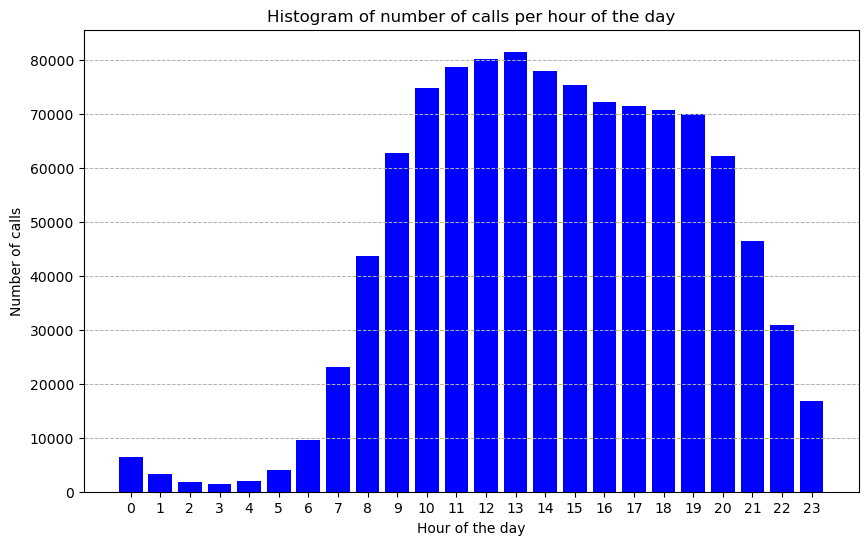

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, md5, when

spark = SparkSession.builder \
    .appName("GranData") \
    .getOrCreate()

events_df = spark.read.option("header", True).csv(f"{extracted_path}/test_grandata_data_engineer/events.csv")

events_df = events_df.filter((events_df["id_source"].isNotNull()) & (events_df["id_destination"].isNotNull()))

events_df = events_df.withColumn("calls", col("calls").cast("integer"))
events_df = events_df.withColumn("seconds", col("seconds").cast("integer"))
events_df = events_df.withColumn("sms", col("sms").cast("integer"))
events_df = events_df.withColumn("region", col("region").cast("integer"))

free_sms_df = spark.read.option("header", True).csv(f"{extracted_path}/test_grandata_data_engineer/free_sms_destinations.csv")

total_billing_amount = events_df.join(free_sms_df, events_df["id_destination"] == free_sms_df["id"], "left") \
    .withColumn("billing_amount",
                when(col("id").isNull(), col("sms") * 0.0)
                .when(col("region").between(1, 5), col("sms") * 1.5)
                .otherwise(col("sms") * 2.0)) \
    .selectExpr("sum(billing_amount) as total_billing_amount")

total_billing_amount.show()

import matplotlib.pyplot as plt

histogram_calls = events_df.groupBy("hour").sum("calls").orderBy("hour")
histogram_calls = histogram_calls.withColumn("hour", col("hour").cast("int")).orderBy("hour").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(histogram_calls["hour"], histogram_calls["sum(calls)"], color='blue')
plt.xlabel("Hour of the day")
plt.ylabel("Number of calls")
plt.title("Histogram of number of calls per hour of the day")
plt.xticks(range(24))  # Make sure all hours of the day are displayed
plt.grid(True, axis='y', linestyle='--', linewidth=0.7)
plt.show()

# Write the top 100 users billing data to a Parquet file
top_100_users_billing = events_df.join(free_sms_df, events_df["id_destination"] == free_sms_df["id"], "left") \
    .withColumn("billing_amount",
                when(col("id").isNull(), col("sms") * 0.0)
                .when(col("region").between(1, 5), col("sms") * 1.5)
                .otherwise(col("sms") * 2.0)) \
    .groupBy("id_source") \
    .sum("billing_amount") \
    .orderBy(col("sum(billing_amount)").desc()) \
    .limit(100) \
    .withColumn("id_hashed", md5(col("id_source")).alias("id_hashed"))

top_100_users_billing.write.parquet(f"{extracted_path}/top_100_users_billing.parquet", compression="gzip", mode="overwrite")